In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import math
import xarray as xr
from multiprocessing import Pool
from scipy import stats

In [2]:
# put your own path here as location_save

location_save="/home/mengxinp/projects/def-mengxinp/mengxinp/Malaria/open_source_code/"

In [4]:
# Data preprocessing for malaria data

##the malaria anomaly is used, as we focus on the year-to-year variation. It is calculated by subtracting the malaria annual cycle 
##(i.e., mean malaria incidence in each calendar epidemiological week during 2000-2022) from the total malaria incidence.

Malaria_peru_yearepiweek_xr=xr.open_dataarray(location_save+"Malaria_Peruvian_Amazon_2000to2022.nc")
Malaria_peru_yearepiweek_xr_mean=Malaria_peru_yearepiweek_xr.mean("year")
Malaria_peru_yearepiweek_xr_anomaly=Malaria_peru_yearepiweek_xr-Malaria_peru_yearepiweek_xr_mean
Malaria_peru_yearepiweek_xr_anomaly.to_netcdf(location_save+"Malaria_anomaly_Peruvian_Amazon_2000to2022.nc")

# Note: To improve the correlation robustness, we concatenate the data for every four epidemiological weeks in the correlation analysis, 
# so you can see the "add" dimension in both SST and Malaria data. It concatenates the data in four sequencial epiweeks. 

Malaria_peru_xr_concatenate=xr.DataArray(np.nan,dims=["year","epiweek","add"],coords={"year":np.arange(2000,2023),"epiweek":np.arange(1,53),"add":np.arange(0,4)})

for year in range(2000,2023):
    for epiweek in range(1,53):
        yearepiweek=year*100+epiweek
        for add in range(0,4):
            # yearepiweek_add=epiweek_list_52[index+add]
            epiweek_add_old=epiweek+add
            if epiweek_add_old>52:
                epiweek_add=epiweek_add_old-52
                year_add=year+1
            else:
                epiweek_add=epiweek_add_old
                year_add=year 
                
            if year_add >2022:
                continue
            Malaria_peru_xr_concatenate.loc[dict(year=year,add=add,epiweek=epiweek)]=Malaria_peru_yearepiweek_xr_anomaly.loc[dict(year=year_add,epiweek=epiweek_add)]

Malaria_peru_xr_concatenate.to_netcdf(location_save+"Malaria_anomaly_Peruvian_Amazon_2000to2022_YearEpiweek_4epiweekconcatenate.nc")


In [5]:
# the processed sea surface temperature data is provided. 

SST_anomaly_yearepiweek=xr.open_dataarray(location_save+"OISSTv2.1_SST_anomaly_detrended_global_1degree_1999to2022_bysubtracting_5daysmovingaverage_calendardaycli_4epiweekconcatenate.nc")
variable_lat=SST_anomaly_yearepiweek['latitude']
variable_long=SST_anomaly_yearepiweek['longitude']


In [ ]:
# Step 1: Lead-lag correlation map pool
    # Generates correlation maps between SSTA fields and disease incidence (e.g., malaria) anomaly time series.
    # with correlation_map_function, you can generate correlation maps for SSTA and disease incidences in different calendar weeks and with different time lags.
    # to improve the calculation efficiency, the parallel computing is applied here. 
    
def correlation_map(lead_lag_week):
    correlation_map_xr=xr.DataArray(np.nan,dims=["correlation","epiweek","latitude","longitude"], \
                                    coords={"correlation":["r_value","p_value","slope","intercept"], \
                                            "epiweek":np.arange(1,53),"latitude":variable_lat,"longitude":variable_long})

    for malaria_epiweek in np.arange(51,52):
    # for malaria_epiweek in np.arange(1,53):
        SST_epiweek_old=malaria_epiweek-lead_lag_week
        if SST_epiweek_old>0:
            SST_epiweek=SST_epiweek_old
            Malaria_anomaly_timeseries=Malaria_anomaly.loc[dict(epiweek=malaria_epiweek,year=slice(2000,2022))]
            SST_anomaly_field=SST_anomaly_yearepiweek.loc[dict(epiweek=SST_epiweek,year=slice(2000,2022))]
        else:
            SST_epiweek=SST_epiweek_old+52
            Malaria_anomaly_timeseries=Malaria_anomaly.loc[dict(epiweek=malaria_epiweek,year=slice(2000,2022))]
            SST_anomaly_field=SST_anomaly_yearepiweek.loc[dict(epiweek=SST_epiweek,year=slice(1999,2021))]            

        print('Malaria anomaly: '+str(malaria_epiweek)+" SSTA: "+str(SST_epiweek))

        add=0
        Malaria_anomaly_timeseries_concatenate=Malaria_anomaly_timeseries.loc[dict(add=add)]
        Malaria_anomaly_timeseries_concatenate=Malaria_anomaly_timeseries_concatenate.assign_coords(year=Malaria_anomaly_timeseries_concatenate['year'].values*10+add)
        SST_anomaly_field_concatenate=SST_anomaly_field.loc[dict(add=add)]
        SST_anomaly_field_concatenate=SST_anomaly_field_concatenate.assign_coords(year=SST_anomaly_field_concatenate['year'].values*10+add)

        for add in range(1,4):
            Malaria_anomaly_timeseries_concatenate_1=Malaria_anomaly_timeseries.loc[dict(add=add)]
            Malaria_anomaly_timeseries_concatenate_1=Malaria_anomaly_timeseries_concatenate_1.assign_coords(year=Malaria_anomaly_timeseries_concatenate_1['year'].values*10+add)
            SST_anomaly_field_concatenate_1=SST_anomaly_field.loc[dict(add=add)]
            SST_anomaly_field_concatenate_1=SST_anomaly_field_concatenate_1.assign_coords(year=SST_anomaly_field_concatenate_1['year'].values*10+add)            
            SST_anomaly_field_concatenate=xr.concat([SST_anomaly_field_concatenate,SST_anomaly_field_concatenate_1],dim='year')
            Malaria_anomaly_timeseries_concatenate=xr.concat([Malaria_anomaly_timeseries_concatenate,Malaria_anomaly_timeseries_concatenate_1],dim='year')
        for lat_index in [41]:
        # for lat_index in range(len(variable_lat)):
            lat=variable_lat[lat_index]
            for long_index in range(len(variable_long)):
                long=variable_long[long_index]
                X_series=SST_anomaly_field_concatenate.loc[dict(latitude=lat,longitude=long)].values
                slope, intercept, r_value, p_value, std_err = stats.linregress(X_series,Malaria_anomaly_timeseries_concatenate)
                correlation_map_xr.loc[dict(epiweek=malaria_epiweek,correlation='r_value',latitude=lat,longitude=long)]=r_value
                correlation_map_xr.loc[dict(epiweek=malaria_epiweek,correlation='p_value',latitude=lat,longitude=long)]=p_value
                correlation_map_xr.loc[dict(epiweek=malaria_epiweek,correlation='slope',latitude=lat,longitude=long)]=slope
                correlation_map_xr.loc[dict(epiweek=malaria_epiweek,correlation='intercept',latitude=lat,longitude=long)]=intercept

    correlation_map_xr.to_netcdf(location_save+"correlation_map_SSTA_vs_malaria_anomaly_eachepiweek_lead"+str(lead_lag_week)+"week.nc")
    return lead_lag_week

pool = Pool(24)
parallel=pool.map(correlation_map,np.arange(0,53)) # this is one year


for lead_lag_week in np.arange(0,53):
    correlation_map_xr=xr.open_dataarray(location_save+"correlation_map_SSTA_vs_malaria_anomaly_eachepiweek_lead"+str(lead_lag_week)+"week.nc")
    correlation_map_xr=correlation_map_xr.assign_coords(lead_lag_week=lead_lag_week)
    if lead_lag_week==0:
        correlation_map_xr_total=correlation_map_xr
    else:
        correlation_map_xr_total=xr.concat([correlation_map_xr_total,correlation_map_xr],dim="lead_lag_week")
correlation_map_xr_total.to_netcdf(location_save+"correlation_map_SSTA_vs_malaria_anomaly_eachepiweek_lead_0to52_week.nc")




In [3]:
# The pool with 2,756 correlation maps can be generated, the computation time will be very long.
# Here, we provide the result directly named "correlation_map_SSTA_vs_malaria_anomaly_eachepiweek_lead_0to52_week_sample.nc" 

correlation_map_xr_total=xr.open_dataarray(location_save+"correlation_map_SSTA_vs_malaria_anomaly_eachepiweek_lead_0to52_week_sample.nc")



1


NameError: name 'variable_long' is not defined

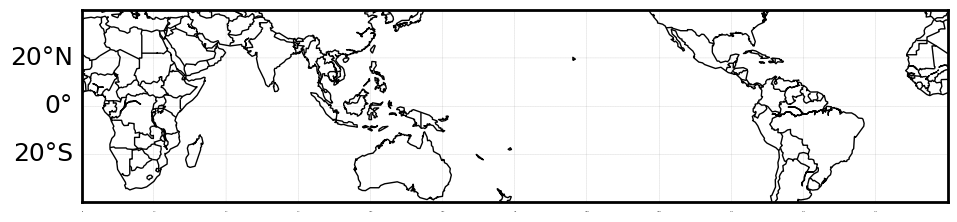

In [4]:
# Figure 2 plot (correlation map plots)
# Here, you can plot the correction map with all lead time and all epiweeks. 

import matplotlib as mpl
import epiweeks
from mpl_toolkits.basemap import Basemap, cm

correlation_map_xr_total=xr.open_dataarray(location_save+"correlation_map_SSTA_vs_malaria_anomaly_eachepiweek_lead_0to52_week_sample.nc")

# color bar defining
level_correlation=np.arange(-0.8,0.9,0.1)
cmap = plt.get_cmap('RdYlBu')
start=1
stop =0
colors = cmap(np.linspace(start, stop, cmap.N))
num_inter=len(level_correlation)-3
colors_self=[]
for i in range(num_inter):
    interv=int(len(colors)/num_inter)
    co=np.array(colors[int(interv*(i+0.7)),0:3])
    colors_self.append(co)
    if i==(num_inter)/2-1:
        colors_self.append(np.array([1,1,1]))
        colors_self.append(np.array([1,1,1]))
        
color_map_correlation = mpl.colors.ListedColormap(colors_self)

plot_range=np.array([[-40,40],[0,360]]) 
        
colors_self=[]
colors_self.append(np.array([1,1,1]))
colors_self.append('#00ffff')
color_map_Peruvian_amazon = mpl.colors.ListedColormap(colors_self)   

fig = plt.figure(figsize=(38,15),facecolor="white") 
plot_index=1
for epiweek in np.arange(1,53,16):
    print(epiweek)
    epiweek_2000=epiweeks.Week(2000,epiweek)
    if epiweek+3<53:
        epiweek_2000_end=epiweeks.Week(2000,epiweek+3)
    else:
        epiweek_2000_end=epiweeks.Week(2000,epiweek+3-52)
    enddate_2000=epiweek_2000_end.enddate()
    startdate_2000=epiweek_2000.startdate()

    for lead_lag_week in [12,24,36]:
        SST_epiweek_old=epiweek-lead_lag_week
        if SST_epiweek_old>0:
            SST_epiweek=SST_epiweek_old
        else:
            SST_epiweek=SST_epiweek_old+52

        epiweek_2000=epiweeks.Week(2000,SST_epiweek)
        if SST_epiweek+3<53:
            epiweek_2000_end=epiweeks.Week(2000,SST_epiweek+3)
        else:
            epiweek_2000_end=epiweeks.Week(2000,SST_epiweek+3-52)
        SST_enddate_2000=epiweek_2000_end.enddate()
        SST_startdate_2000=epiweek_2000.startdate()

        SST_rvalue_map=correlation_map_xr_total.loc[dict(lead_lag_week=lead_lag_week,epiweek=epiweek,correlation='r_value')]

        interval=4
        SST_Rvalue_pvalue_map=correlation_map_xr_total.loc[dict(lead_lag_week=lead_lag_week,epiweek=epiweek,correlation=['r_value','p_value'])]
        SST_Rvalue_pvalue_map_group_long=SST_Rvalue_pvalue_map.groupby_bins('longitude',np.arange(0,360+interval,interval),right=False).mean()
        SST_Rvalue_pvalue_map_group_long=SST_Rvalue_pvalue_map_group_long.rename(longitude_bins='longitude')
        SST_Rvalue_pvalue_map_group_long=SST_Rvalue_pvalue_map_group_long.assign_coords(longitude=np.arange(int(interval/2),360,interval))
        SST_Rvalue_pvalue_map_group_long=SST_Rvalue_pvalue_map_group_long[:,::-1,:]
        SST_Rvalue_pvalue_map_group_long_lat=SST_Rvalue_pvalue_map_group_long.groupby_bins('latitude',np.arange(-90,90+interval,interval),right=False).mean()
        SST_Rvalue_pvalue_map_group_long_lat=SST_Rvalue_pvalue_map_group_long_lat.rename(latitude_bins='latitude')
        SST_Rvalue_pvalue_map_group_long_lat=SST_Rvalue_pvalue_map_group_long_lat.assign_coords(latitude=np.arange(-90+int(interval/2),90,interval))

        sig_index=np.where(SST_Rvalue_pvalue_map_group_long_lat.loc[dict(correlation='p_value')]<0.001)
        SST_rvalue_sig_scatter_value=SST_Rvalue_pvalue_map_group_long_lat.loc[dict(correlation='r_value')].values[sig_index]
        SST_rvalue_sig_scatter_long=SST_Rvalue_pvalue_map_group_long_lat['longitude'].values[sig_index[1]]
        SST_rvalue_sig_scatter_lat=SST_Rvalue_pvalue_map_group_long_lat['latitude'].values[sig_index[0]]
    
        ax=plt.subplot(4,3, plot_index) # 
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        plot_index=plot_index+1

        m = Basemap(projection='cyl',\
                    llcrnrlat=plot_range[0,0],urcrnrlat=plot_range[0,1],\
                    llcrnrlon=plot_range[1,0],urcrnrlon=plot_range[1,1])
        # draw coastlines, state and country boundaries, edge of map.
        m.drawcoastlines()
        m.drawcountries(linewidth=1)
        parallels = np.arange(-20,plot_range[0,1],20)
        if lead_lag_week==12:
            m.drawparallels(parallels,labels=[1,0,0,0],fontsize=18,linewidth=0.1)#left, right, top, bottom
        else:
            m.drawparallels(parallels,labels=[1,0,0,0],fontsize=0,linewidth=0.1)#left, right, top, bottom
        # draw meridians
        meridians = np.arange(0,plot_range[1,1],30)
        if epiweek==49:
            m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=18,linewidth=0.1)
        else:
            m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=0,linewidth=0.1)
        xx, yy = m(*np.meshgrid(variable_long,variable_lat))
        pa_R=plt.contourf(xx, yy ,SST_rvalue_map,level_correlation,cmap=color_map_correlation,extend='both',alpha=0.8)#level_SST
        plt.plot([190,240,240,190,190],[-5,-5,5,5,-5],linewidth=2.5,color='blue')
        plt.scatter(SST_rvalue_sig_scatter_long,SST_rvalue_sig_scatter_lat,s=5,color='black')

        date_str_SST=str(SST_startdate_2000)[5:10]+" to "+ str(SST_enddate_2000)[5:10]
        date_str=str(startdate_2000)[5:10]+" to "+ str(enddate_2000)[5:10]
        
        title='Lead time: '+str(lead_lag_week)+' weeks'+' [SST week '+str(SST_epiweek)+'-'+str(SST_epiweek+3)+' ('+date_str_SST+') & malaria week '+str(epiweek)+'-'+str(epiweek+3)+' ('+date_str+')]'
        plt.title(title,fontsize=17)
        plt.rcParams["font.family"]="serif"

fig.subplots_adjust(bottom=0.11, top=0.97, left=0.03, right=0.98,wspace=0.03,hspace=0.1)

cb_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])
cbar = fig.colorbar(pa_R, cax=cb_ax,orientation='horizontal')    
cbar.ax.tick_params(labelsize=30) 
cbar.set_label('Correlation', fontsize=30)

filename=location_save+'Figure2 Correlation map SSTA vs Malaria anomaly over Loreto.png'      
plt.savefig(filename,dpi=200) 



In [11]:

# data preparation for Self-organizing Map (machine learning clustering algorithm)
# correlation maps with longitude and latitude need to be flattened into one dimension (the grids dimension in SOM_function)

correlation_map_xr_total=xr.open_dataarray(location_save+"correlation_map_SSTA_vs_malaria_anomaly_eachepiweek_lead_0to52_week_sample.nc").loc[dict(correlation='r_value')]

correlation_map_xr_total_group_long=correlation_map_xr_total.groupby_bins('longitude',np.arange(0,362,2),right=False).mean()
correlation_map_xr_total_group_long=correlation_map_xr_total_group_long.rename(longitude_bins='longitude')
correlation_map_xr_total_group_long=correlation_map_xr_total_group_long.assign_coords(longitude=np.arange(0,360,2))
correlation_map_xr_total_group_long_lat=correlation_map_xr_total_group_long.groupby_bins('latitude',np.arange(-40,42,2),right=False).mean()
correlation_map_xr_total_group_long_lat=correlation_map_xr_total_group_long_lat.rename(latitude_bins='latitude')
correlation_map_xr_total_group_long_lat=correlation_map_xr_total_group_long_lat.assign_coords(latitude=np.arange(-40,40,2))

correlation_map_xr_total_group_long_lat.to_netcdf(location_save+"correlation_map_SSTA_vs_malaria_anomaly_eachepiweek_2degree_lead0to52_week.nc")


lead_lag_week_list=correlation_map_xr_total_group_long_lat['lead_lag_week'].values
epiweek_list=correlation_map_xr_total_group_long_lat['epiweek'].values
variable_lat=correlation_map_xr_total_group_long_lat['latitude'].values
variable_long=correlation_map_xr_total_group_long_lat['longitude'].values

epiweek_leadtime_list=[]
for lead_lag_week in lead_lag_week_list:
    for epiweek in epiweek_list:
        epiweek_leadtime=epiweek*1000+lead_lag_week
        epiweek_leadtime_list.append(epiweek_leadtime)
        
reorganized_correlation_map_xr=xr.DataArray(np.nan,dims=["epiweek_leadtime","latitude","longitude"], \
                                            coords={"epiweek_leadtime":epiweek_leadtime_list,"latitude":variable_lat,"longitude":variable_long})

epiweek_leadtime_list=[]
for lead_lag_week in lead_lag_week_list:
    for epiweek in epiweek_list:
        epiweek_leadtime=epiweek*1000+lead_lag_week
        reorganized_correlation_map_xr.loc[dict(epiweek_leadtime=epiweek_leadtime)]=correlation_map_xr_total_group_long_lat.loc[dict(epiweek=epiweek,lead_lag_week=lead_lag_week)]

reorganized_correlation_map_xr.to_netcdf(location_save+"correlation_map_SSTA_vs_malaria_anomaly_eachepiweek_lead_0to52_week_reorganized_forSOM.nc")


reorganized_correlation_map_xr=xr.open_dataarray(location_save+"correlation_map_SSTA_vs_malaria_anomaly_eachepiweek_lead_0to52_week_reorganized_forSOM.nc")
reorganized_correlation_map_xr_large=reorganized_correlation_map_xr.where(abs(reorganized_correlation_map_xr)>0.2,0)
reorganized_correlation_map_xr_example=reorganized_correlation_map_xr_large[0,:,:]
# plt.pcolor(reorganized_correlation_map_xr[0,:,:])

reorganized_correlation_map_xr_example=reorganized_correlation_map_xr[0,:,:]
target_index=np.where(np.isnan(reorganized_correlation_map_xr_example)==False)
lat_index=target_index[0]
lon_index=target_index[1]
num_grid=len(lon_index)
AR_freq_total_01=np.zeros(np.shape(reorganized_correlation_map_xr_example))
AR_freq_total_01[target_index]=1
# plt.pcolor(AR_freq_total_01)

epiweek_leadtime_list=reorganized_correlation_map_xr_large["epiweek_leadtime"].values
reorganized_correlation_map_xr_large_series=reorganized_correlation_map_xr_large.values[:,lat_index,lon_index]
reorganized_correlation_map_xr_large_series_forSOM=xr.DataArray(reorganized_correlation_map_xr_large_series,dims=["epiweek_leadtime","grid_index"], \
                                                                  coords={"epiweek_leadtime":epiweek_leadtime_list,"grid_index":np.arange(0,num_grid)})

reorganized_correlation_map_xr_large_series_forSOM.to_netcdf(location_save+"correlation_map_SSTA_vs_malaria_anomaly_eachepiweek_lead_0to52_week_reorganized_forSOM_Rmorethan02.nc")




In [ ]:
# Step 2: Machine learning clustering
# To identify correlation map groups with similar spatial patterns and temporal continuity by Self-organizing Map (SOM).

# In step 2, we used the a R package to apply SOM, please use the SST_malaria.R code to conduct step 2


In [5]:
# Step 2: Machine learning clustering
# Here, we process and visualize the result of SOM from "SST_malaria.R" code
# again we provide a sample, i.e., the result of our study directly 
# named "SOM_result_cluster_list_correlation_map_SSTA_vs_malaria_anomaly_eachepiweek_lead_0to52_week_reorganized_forSOM_Rmorethan02.nc" 

version_name="correlation_map_SSTA_vs_malaria_anomaly_eachepiweek_lead_0to52_week_reorganized_forSOM_Rmorethan02"
cluster_list=xr.open_dataarray(location_save+"SOM_result_cluster_list_"+version_name+".nc")

reorganized_correlation_map_xr=xr.open_dataarray(location_save+"correlation_map_SSTA_vs_malaria_anomaly_eachepiweek_lead_0to52_week_reorganized_forSOM.nc")

seed=1
epiweek_leadtime_list=reorganized_correlation_map_xr['epiweek_leadtime'].values
cluster_list=cluster_list.assign_coords(epiweek_leadtime=epiweek_leadtime_list)
num_cluster_list=cluster_list['num_cluster'].values



In [6]:
import epiweeks 

epiweek_ticks_list=[]
for epiweek in np.arange(1,53):
    epiweek_2000=epiweeks.Week(2000,epiweek)
    if epiweek+3<53:
        epiweek_2000_end=epiweeks.Week(2000,epiweek+3)
    else:
        epiweek_2000_end=epiweeks.Week(2000,epiweek+3-52)
    enddate_2000=epiweek_2000_end.enddate()
    startdate_2000=epiweek_2000.startdate()
    date_str=str(epiweek)+': '+str(startdate_2000)[5:10]
    epiweek_ticks_list.append(date_str)

    
# The SOM result will be randomly organized, for better visualization, we can define the name of different clusters manually. 

cluster_name_customized_dic={}
cluster_name_customized_dic[1]=4
cluster_name_customized_dic[2]=3
cluster_name_customized_dic[3]=1
cluster_name_customized_dic[4]=2

from_customized_to_cluster_name_dic={}
from_customized_to_cluster_name_dic[1]=3
from_customized_to_cluster_name_dic[2]=4
from_customized_to_cluster_name_dic[3]=2
from_customized_to_cluster_name_dic[4]=1


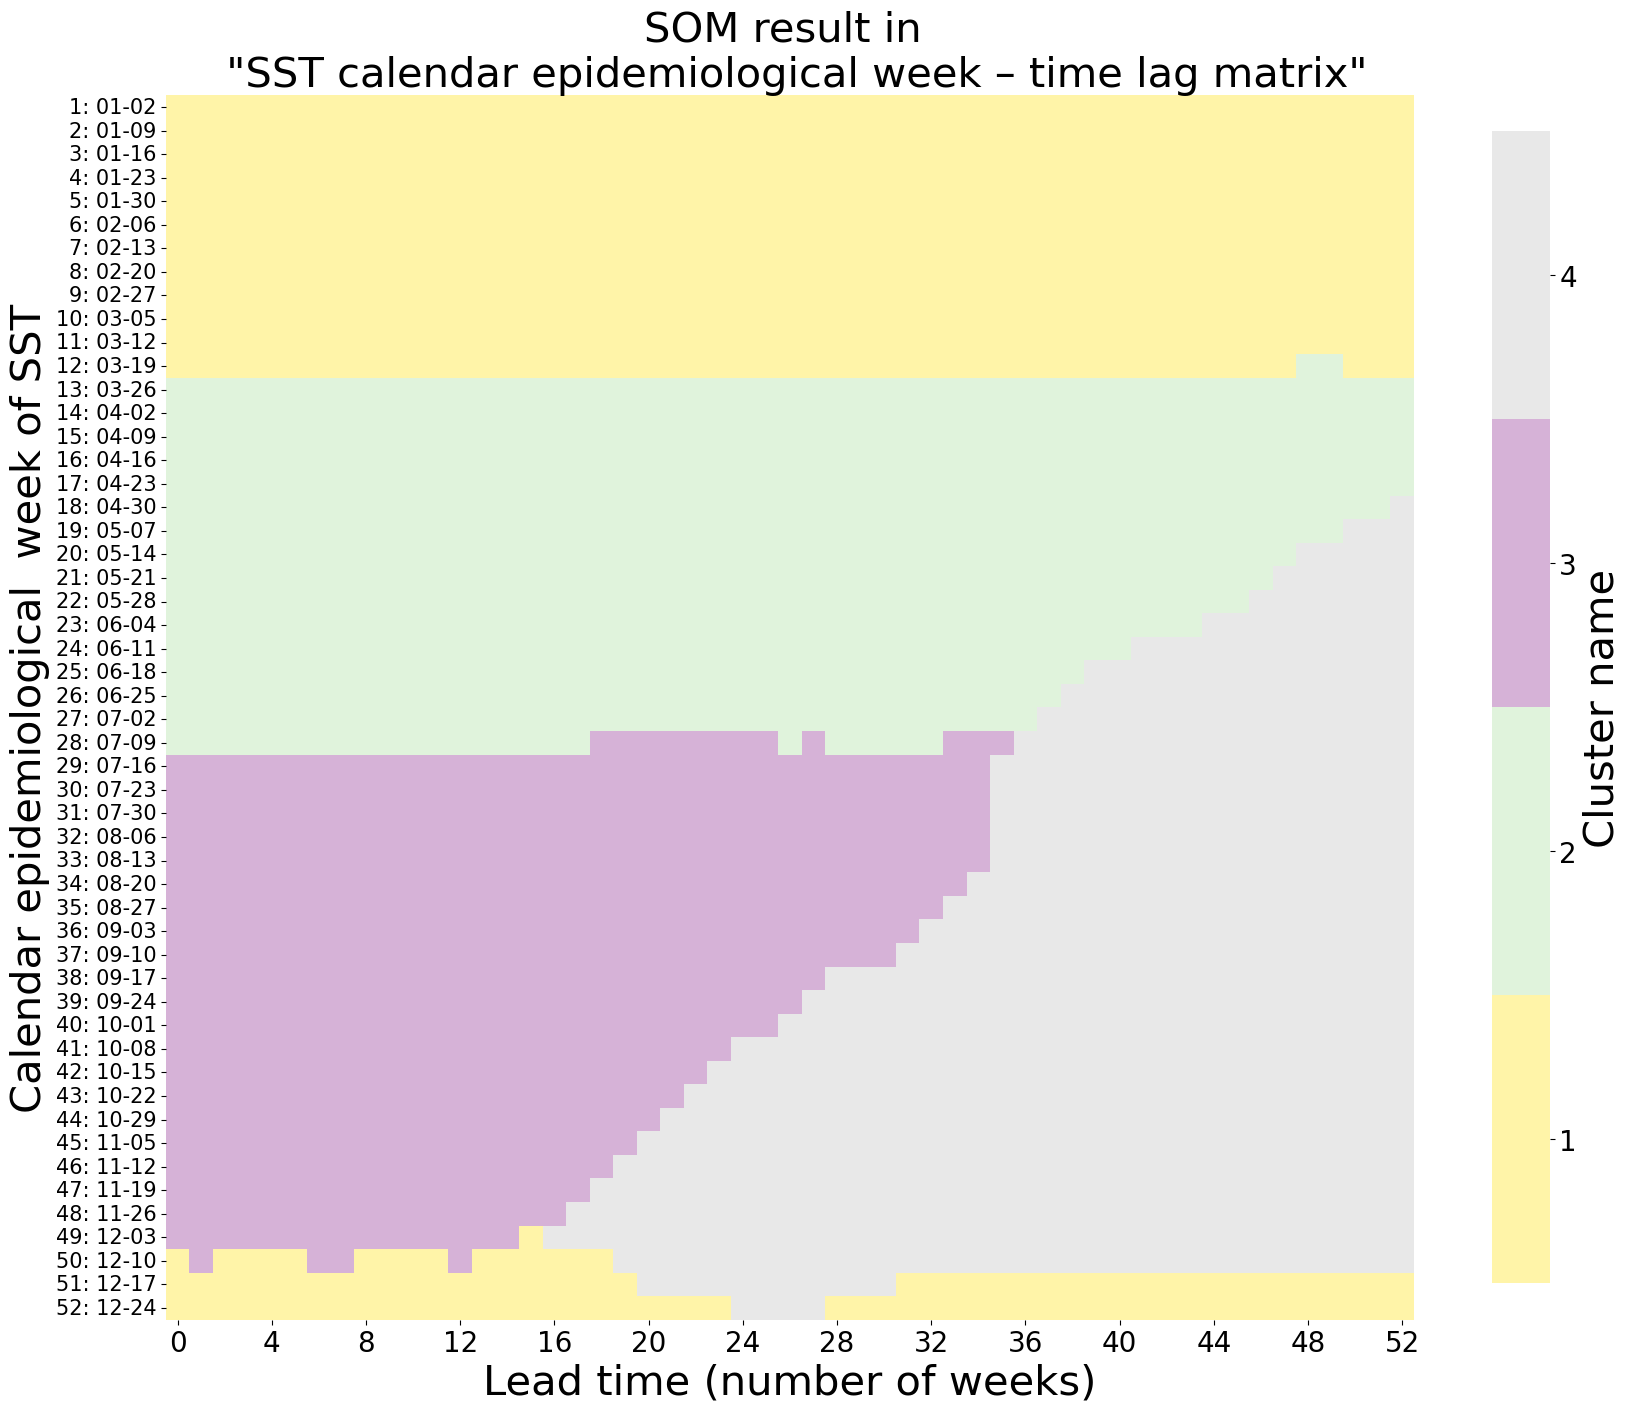

In [9]:
# Figure 3 result of clustering 
import seaborn as sn
import matplotlib as mpl

lead_lag_week_list=correlation_map_xr_total['lead_lag_week'].values
epiweek_list=correlation_map_xr_total['epiweek'].values
variable_lat=correlation_map_xr_total['latitude'].values
variable_long=correlation_map_xr_total['longitude'].values

num_cluster=4

level_correlation=np.arange(1,num_cluster+1)
cmap = plt.get_cmap('Set3')
start=1
stop =0
colors = cmap(np.linspace(start, stop, cmap.N))
num_inter=len(level_correlation)
interv=int(len(colors)/10)
colors_self=[]
for i in range(num_inter):
    co=np.array(colors[int(interv*(i+0.7)),0:3])
    colors_self.append(co)
color_map_correlation = mpl.colors.ListedColormap(colors_self)


target_cluster_list=cluster_list.loc[dict(num_cluster=num_cluster,seed=seed)]
cluster_name_list=list(set(list(target_cluster_list.values)))
SSTepiweek_leadweek_pd=pd.DataFrame(0.0,columns=lead_lag_week_list,index=epiweek_list)
for cluster_name in cluster_name_list:
    cluster_name_customized=cluster_name_customized_dic[cluster_name]
    target_epiweek_leadtime_list=epiweek_leadtime_list[np.where(target_cluster_list==cluster_name)[0]]
    for epiweek_leadtime in target_epiweek_leadtime_list:
        epiweek_Malaria=int(epiweek_leadtime/1000)
        lead_lag_week=epiweek_leadtime-epiweek_Malaria*1000

        epiweek_SST=epiweek_Malaria-lead_lag_week
        if epiweek_SST<1:
            epiweek_SST=epiweek_SST+52
        SSTepiweek_leadweek_pd.loc[epiweek_SST,lead_lag_week]=cluster_name_customized

correlation_matrix=SSTepiweek_leadweek_pd.astype(int)

fig= plt.figure(figsize=(20,16),facecolor="white")
ax=sn.heatmap(correlation_matrix, annot=False,cmap=color_map_correlation,vmax=np.max(cluster_name_list)+1,vmin=np.min(cluster_name_list),alpha=0.6,square=True,annot_kws={"fontsize":8,"color":'black'}, \
              cbar_kws = dict(use_gridspec=True,location="right",shrink=0.9,ticks=level_correlation+0.5,label='cluster name'),cbar=True,fmt="d")

ax.figure.axes[-1].set_ylabel('Cluster name', size=30)
ax.collections[0].colorbar.set_ticklabels(level_correlation, size=20)

plt.ylabel('Calendar epidemiological  week of SST',fontsize=30)
plt.xticks(lead_lag_week_list[::4]+0.5,lead_lag_week_list[::4],fontsize=20)
plt.yticks(np.arange(0,np.shape(correlation_matrix)[0])+0.5,epiweek_ticks_list,fontsize=15,rotation = 0)
plt.xlabel('Lead time (number of weeks)',fontsize=30)
plt.title('SOM result in \n "SST calendar epidemiological week – time lag matrix"',fontsize=30)
fig.subplots_adjust(bottom=0.15, top=0.95, left=0.2, right=0.98,wspace=0.1,hspace=0.1)

filename=location_save+'Figure3 Distribution of each cluster organized by SSTA calendar weeks.png'
plt.savefig(filename,dpi=200)



4


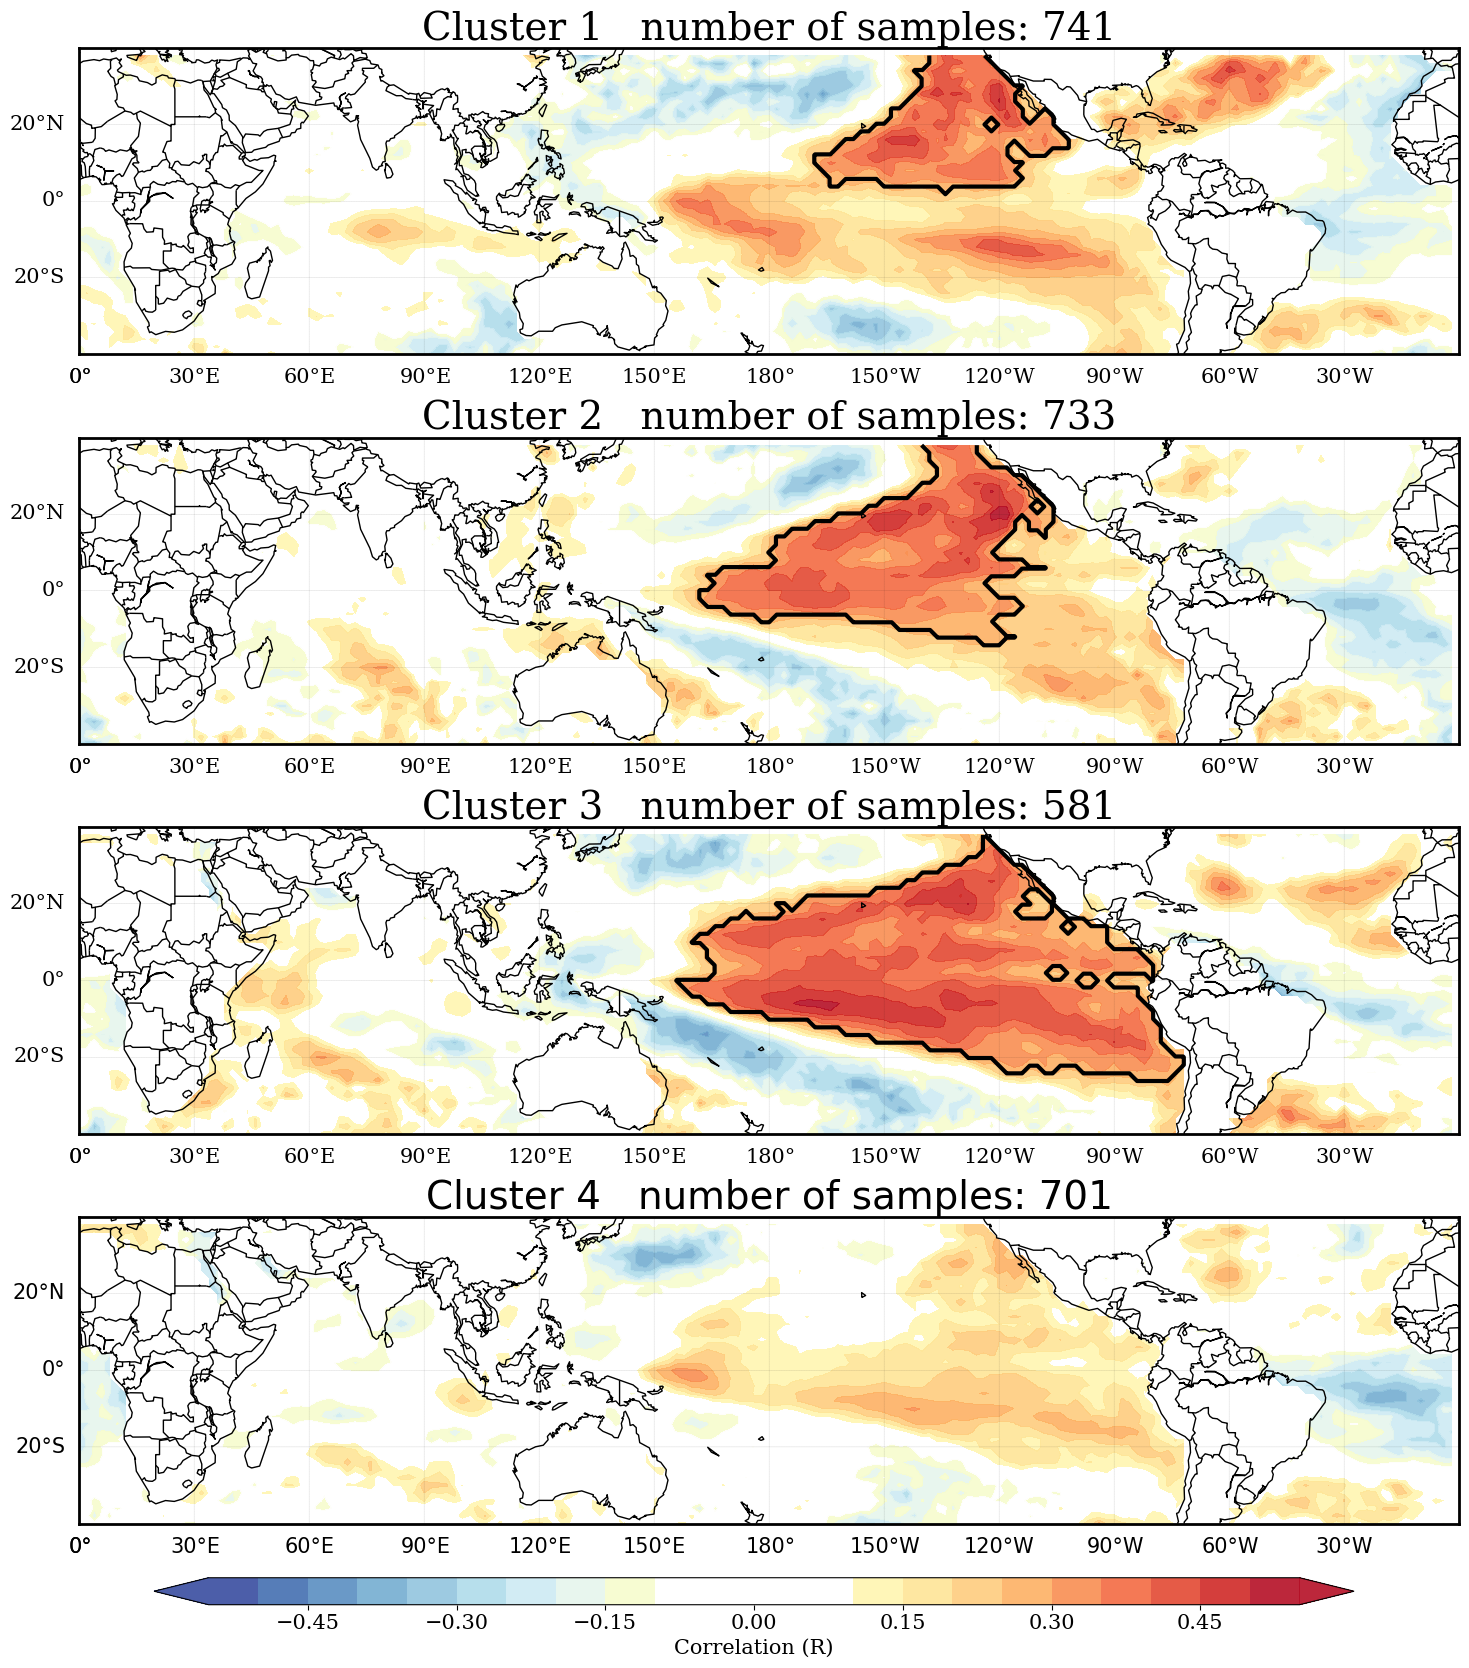

In [10]:
from skimage.measure import label
import collections
from PIL import ImageColor
from mpl_toolkits.basemap import Basemap, cm

level_correlation=np.arange(-0.55,0.6,0.05)
cmap = plt.get_cmap('RdYlBu')
start=1
stop =0
colors = cmap(np.linspace(start, stop, cmap.N))
num_inter=len(level_correlation)-5
colors_self=[]
for i in range(num_inter):
    interv=int(len(colors)/num_inter)
    co=np.array(colors[int(interv*(i+0.7)),0:3])
    colors_self.append(co)
    if i==(num_inter)/2-1:
        colors_self.append(np.array([1,1,1]))
        colors_self.append(np.array([1,1,1]))
        colors_self.append(np.array([1,1,1]))
        colors_self.append(np.array([1,1,1]))
color_map_correlation = mpl.colors.ListedColormap(colors_self)


reorganized_correlation_map_xr=xr.open_dataarray(location_save+"correlation_map_SSTA_vs_malaria_anomaly_eachepiweek_lead_0to52_week_reorganized_forSOM.nc")

variable_lat=reorganized_correlation_map_xr['latitude'].values
variable_long=reorganized_correlation_map_xr['longitude'].values  
mean_correlation_map_eachcluster=xr.DataArray(np.nan,dims=["cluster_name","latitude","longitude"], \
                                coords={"cluster_name":np.arange(1,5),"latitude":variable_lat,"longitude":variable_long})

predictor_label_field_xr=xr.DataArray(np.nan,dims=["cluster_name","latitude","longitude"], \
                                coords={"cluster_name":np.arange(1,5),"latitude":variable_lat,"longitude":variable_long})


plot_range=np.array([[-40,40],[0,360]])    
seed=1

mean_abs_R_value_predictor_color_list=[np.array(ImageColor.getcolor("#f032e6", "RGB"))/255,np.array(ImageColor.getcolor("#3cb44b", "RGB"))/255,np.array(ImageColor.getcolor("#000075", "RGB"))/255, \
                                           np.array(ImageColor.getcolor("#42d4f4", "RGB"))/255, np.array(ImageColor.getcolor("#1F51FF", "RGB"))/255, \
                                      np.array(ImageColor.getcolor("#FF3131", "RGB"))/255 ,np.array(ImageColor.getcolor("#7F00FF", "RGB"))/255]

threshold=0.25
num_cluster=4

print(num_cluster)
target_cluster_list=cluster_list.loc[dict(num_cluster=num_cluster,seed=seed)]
cluster_name_list=list(set(list(target_cluster_list.values)))

fig = plt.figure(figsize=(15,18),facecolor="white")
plot_index=1        
for cluster_name in cluster_name_list:
    cluster_name_customized=cluster_name_customized_dic[cluster_name]
    target_epiweek_leadtime_list=epiweek_leadtime_list[np.where(target_cluster_list==cluster_name)[0]]

    target_AR_occurrence=reorganized_correlation_map_xr.loc[dict(epiweek_leadtime=target_epiweek_leadtime_list)]
    mean_correlation_map=target_AR_occurrence.mean("epiweek_leadtime")
    mean_correlation_map_eachcluster.loc[dict(cluster_name=cluster_name)]=mean_correlation_map

    sig_index=np.where(abs(mean_correlation_map)>threshold)
    SST_rvalue_sig_scatter_long=variable_long[sig_index[1]]
    SST_rvalue_sig_scatter_lat=variable_lat[sig_index[0]]

    mean_correlation_map_large=mean_correlation_map.where(abs(mean_correlation_map)>threshold,0)
    mean_correlation_map_large_01field=mean_correlation_map_large.where(mean_correlation_map_large==0,1)
    high_correlation_labeled=label(mean_correlation_map_large_01field, connectivity=2,background=0)
    label_number_list=list(high_correlation_labeled[np.where(high_correlation_labeled!=0)])    
    label_list_2grid=[item for item, count in collections.Counter(label_number_list).items() if count>50]

    ax=plt.subplot(4,1,cluster_name_customized)

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)

    plot_index=plot_index+1
    m = Basemap(projection='cyl',\
                llcrnrlat=plot_range[0,0],urcrnrlat=plot_range[0,1],\
                llcrnrlon=plot_range[1,0],urcrnrlon=plot_range[1,1])
    # draw coastlines, state and country boundaries, edge of map.
    m.drawcoastlines()
    m.drawcountries(linewidth=1)
    parallels = np.arange(-20,40,20)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=15,linewidth=0.1)#left, right, top, bottom
    # draw meridians
    meridians = np.arange(-180,360,30)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=15,linewidth=0.1)

    xx, yy = m(*np.meshgrid(variable_long,variable_lat))
    pa=plt.contourf(xx, yy ,mean_correlation_map,level_correlation,cmap=color_map_correlation,extend='both',alpha=0.9)

    if cluster_name_customized <4:
        each_high_correlation_labeled=np.zeros(np.shape(high_correlation_labeled))
        label_number_restart=1
        for label_number in label_list_2grid:
            tp_patches_location=np.where(high_correlation_labeled==label_number)
            each_high_correlation_labeled[tp_patches_location]=label_number_restart
            label_number_restart=label_number_restart+1
            
        predictor_label_field_xr.loc[dict(cluster_name=cluster_name)]=each_high_correlation_labeled
        if cluster_name_customized==3:
            label_number=2
        elif cluster_name_customized==2:
            label_number=2
        elif cluster_name_customized==1:
            label_number=3
            
        predictor_field_plot=np.zeros(np.shape(each_high_correlation_labeled))
        scatter_index=np.where(each_high_correlation_labeled==label_number)
        predictor_field_plot[scatter_index]=1
        colors_self=[]
        colors_self.append(np.array([1,1,1]))
        colors_self.append('black')
        color_map_ar_genesis_contour = mpl.colors.ListedColormap(colors_self)   
        pa1=plt.contour(xx, yy ,predictor_field_plot,[-10,0.9],cmap=color_map_ar_genesis_contour,linestyles='solid',\
                        extend='both',alpha=1,linewidths=3)#dotted

    title='Cluster '+str(cluster_name_customized) +'   number of samples: '+str(len(target_epiweek_leadtime_list)) #subtitle_index_list[cluster_name_customized+1]+
    plt.title(title,fontsize=28)
    plt.rcParams["font.family"]="serif"

fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.97,wspace=0.08,hspace=0.08)
cb_ax2 = fig.add_axes([0.1, 0.07, 0.8, 0.015])
cbar2 = fig.colorbar(pa, cax=cb_ax2,orientation='horizontal')
cbar2.ax.tick_params(labelsize=15)
cbar2.set_label('Correlation (R)', fontsize=15)
filename=location_save+'Figure3_SOM_result_Peru_Malaria_correlation_map_'+version_name+"_seed"+str(seed)+'_'+str(num_cluster)+'C.png'
plt.savefig(filename,dpi=100) 
# plt.close()     



In [11]:
# Step 3: Dynamic SST index identification
# To select the high correlation region over tropical ocean as the SST monitoring regions for each cluster.

from skimage.measure import label
import collections

reorganized_correlation_map_xr=xr.open_dataarray(location_save+"correlation_map_SSTA_vs_malaria_anomaly_eachepiweek_lead_0to52_week_reorganized_forSOM.nc")
variable_lat=reorganized_correlation_map_xr['latitude'].values
variable_long=reorganized_correlation_map_xr['longitude'].values  

predictor_label_field_xr=xr.DataArray(np.nan,dims=["cluster_name","latitude","longitude"], \
                                coords={"cluster_name":np.arange(1,4),"latitude":variable_lat,"longitude":variable_long})

seed=1
threshold=0.25
num_cluster=4

version_name="correlation_map_SSTA_vs_malaria_anomaly_eachepiweek_lead_0to52_week_reorganized_forSOM_Rmorethan02"
cluster_list=xr.open_dataarray(location_save+"SOM_result_cluster_list_"+version_name+".nc")

target_cluster_list=cluster_list.loc[dict(num_cluster=num_cluster,seed=seed)]
cluster_name_list=list(set(list(target_cluster_list.values)))

       
for cluster_name in cluster_name_list:
    cluster_name_customized=cluster_name_customized_dic[cluster_name]
    target_epiweek_leadtime_list=epiweek_leadtime_list[np.where(target_cluster_list==cluster_name)[0]]

    target_AR_occurrence=reorganized_correlation_map_xr.loc[dict(epiweek_leadtime=target_epiweek_leadtime_list)]
    mean_correlation_map=target_AR_occurrence.mean("epiweek_leadtime")

    sig_index=np.where(abs(mean_correlation_map)>threshold)
    SST_rvalue_sig_scatter_long=variable_long[sig_index[1]]
    SST_rvalue_sig_scatter_lat=variable_lat[sig_index[0]]

    mean_correlation_map_large=mean_correlation_map.where(abs(mean_correlation_map)>threshold,0)
    mean_correlation_map_large_01field=mean_correlation_map_large.where(mean_correlation_map_large==0,1)
    tp_labeled=label(mean_correlation_map_large_01field, connectivity=2,background=0)
    label_number_list=list(tp_labeled[np.where(tp_labeled!=0)])    
    label_list_2grid=[item for item, count in collections.Counter(label_number_list).items() if count>50]

    if cluster_name_customized <4:
        rain_patches_label=np.zeros(np.shape(tp_labeled))
        label_number_restart=1
        for label_number in label_list_2grid:
            tp_patches_location=np.where(tp_labeled==label_number)
            rain_patches_label[tp_patches_location]=label_number_restart
            label_number_restart=label_number_restart+1

        if cluster_name_customized==3:
            label_number=2
        elif cluster_name_customized==2:
            label_number=2
        elif cluster_name_customized==1:
            label_number=3
        # for label_number in range(0,5):

        # for label_number in range(1,int(np.max(rain_patches_label))+1):
        predictor_field_plot=np.zeros(np.shape(rain_patches_label))
        scatter_index=np.where(rain_patches_label==label_number)
        predictor_field_plot[scatter_index]=1
        predictor_label_field_xr.loc[dict(cluster_name=cluster_name_customized)]=predictor_field_plot

predictor_label_field_xr.to_netcdf(location_save+"dynamic_SST_index_three_SST_monitoring_region.nc")


In [12]:
# Step 3: Dynamic SST index is the average SST anomaly over the monitoring regions. 


SST_anomaly_yearepiweek=xr.open_dataarray(location_save+"OISSTv2.1_SST_anomaly_detrended_global_1degree_1999to2022_bysubtracting_5daysmovingaverage_calendardaycli_4epiweekconcatenate.nc").sel(add=0)
predictor_label_field_xr=xr.open_dataarray(location_save+"dynamic_SST_index_three_SST_monitoring_region.nc")
predictor_label_field_xr=predictor_label_field_xr.interp(latitude=SST_anomaly_yearepiweek['latitude'],longitude=SST_anomaly_yearepiweek['longitude'])

SST_yearepiweek_list=[]
for current_year in range(1999,2023):
    for current_week in range(1,53):
        SST_yearepiweek_list.append(current_year*100+current_week)     
SST_yearepiweek_list=np.array(SST_yearepiweek_list).astype(int)

dynamic_SST_index_pd=pd.DataFrame(np.nan,index=SST_yearepiweek_list,columns=['dynamic_SST_index'])

for SST_year in range(1999,2023):
    end_epiweek=52
    for SST_week in range(1,end_epiweek+1):
        if SST_week > 49 or SST_week < 12:
            cluster_name=1
        elif SST_week >= 12 and SST_week < 28:
            cluster_name=2
        else:
            cluster_name=3
            
        predictor_label_region=predictor_label_field_xr.loc[dict(cluster_name=cluster_name)]
        grid_number=np.sum(predictor_label_region).values
        detrended_SST_current=SST_anomaly_yearepiweek.loc[dict(year=SST_year,epiweek=SST_week)]

        detrended_SST_current_prediction_field=detrended_SST_current*predictor_label_region
        detrended_SST_current_prediction=detrended_SST_current_prediction_field.sum('latitude').sum('longitude').values/grid_number
        
        dynamic_SST_index_pd.loc[SST_year*100+SST_week,:]=detrended_SST_current_prediction

dynamic_SST_index_pd.to_csv(location_save+"dynamic_SST_index_1999to2022.csv")

dynamic_SST_index_pd_4week_sum=pd.DataFrame(np.nan,index=SST_yearepiweek_list,columns=np.arange(0,4))
dynamic_SST_index_pd_4week_sum.loc[SST_yearepiweek_list[:],0]=dynamic_SST_index_pd['dynamic_SST_index'].values
dynamic_SST_index_pd_4week_sum.loc[SST_yearepiweek_list[:-1],1]=dynamic_SST_index_pd['dynamic_SST_index'].values[1:]
dynamic_SST_index_pd_4week_sum.loc[SST_yearepiweek_list[:-2],2]=dynamic_SST_index_pd['dynamic_SST_index'].values[2:]
dynamic_SST_index_pd_4week_sum.loc[SST_yearepiweek_list[:-3],3]=dynamic_SST_index_pd['dynamic_SST_index'].values[3:]
dynamic_SST_index_pd_4week_mean=dynamic_SST_index_pd_4week_sum.mean(axis=1)
dynamic_SST_index_pd_4week_mean.to_csv(location_save+"dynamic_SST_index_4weekly_1999to2022.csv")

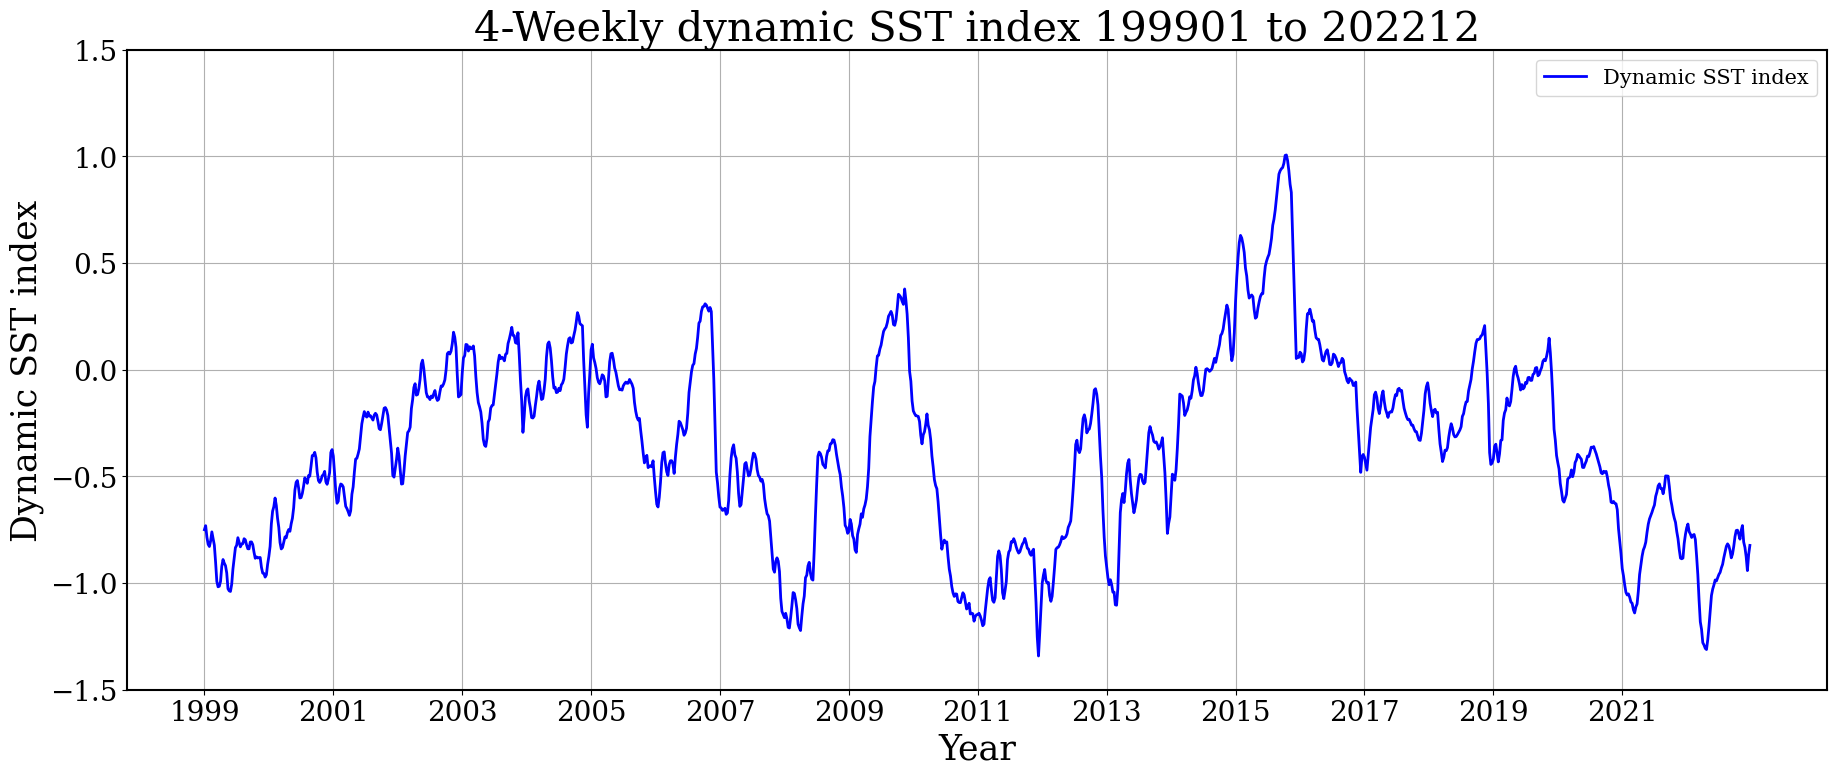

In [13]:


fig= plt.figure(figsize=(20,8))
ax=plt.subplot(1,1,1)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5) 

plt.plot(np.arange(0,len(dynamic_SST_index_pd_4week_mean)),dynamic_SST_index_pd_4week_mean,linewidth=2,label='Dynamic SST index', linestyle='-', color='b',zorder=5)
plt.rcParams["font.family"]="serif"

plt.xticks(np.arange(0,len(dynamic_SST_index_pd_4week_mean),52*2),np.arange(1999,2023,2),fontsize=20)
plt.legend(fontsize=15,loc='upper right')
plt.ylabel("Dynamic SST index",fontsize=25)
plt.yticks(np.arange(-1.5,1.6,0.5),fontsize=20)
# plt.ylim([-2500,5500])
plt.xlabel("Year",fontsize=25)
# plt.title(title,fontsize=30)
plt.rcParams["font.family"]="serif"
plt.title('4-Weekly dynamic SST index 199901 to 202212',fontsize=30)
# plt.title('Observed vs predicted Malaria anomaly by dynamic SST index (prediction lead time 0 weeks)',fontsize=25)
plt.grid()
# plt.legend(fontsize=20,loc="upper left")
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.95)
filename=location_save+'plot 4-weekly Dynamic SST index.png'
plt.savefig(filename,dpi=200) 
# plt.plot()


In [ ]:
# Prediction performance assessment by generalized linear model (GLM). 

